# Primordial non-Gaussianity examples

In this notebook we will show how to perform PNG fits to data power spectrum.
Look first at notebooks basic_examples.ipynb to get a flavor of *desilike* mechanisms.

## Fake power spectrum data

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI

cosmo = DESI()
edges = np.linspace(0., 0.3, 61)
k = (edges[:-1] + edges[1:]) / 2.
nmodes = 4. * np.pi / 3. * (edges[1:]**3 - edges[:-1]**3)
z = 1.
fo = cosmo.get_fourier()
pk = fo.pk_interpolator(of='delta_cb')(k, z=z)
pk_prim = cosmo.get_primordial(mode='scalar').pk_interpolator()(k)
pphi_prim = 9 / 25 * 2 * np.pi**2 / k**3 * pk_prim / cosmo.h**3
alpha = 1. / (pk / pphi_prim)**0.5

fnl = 100.
# PNG response of dark matter halos in spherical collapse
b1 = 2.
bphi = 2. * 1.686 * (b1 - 1.)
b = b1 + bphi * fnl * alpha
f = fo.sigma8_z(z, of='theta_cb') / fo.sigma8_z(z, of='delta_cb')
shotnoise = 1 / 1e-4
volume = 1e9

ells = (0, 2)
poles = []
poles.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk + shotnoise)
poles.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
poles = np.array(poles, dtype='f8')

from pypower import PowerSpectrumStatistics
mean = PowerSpectrumStatistics(edges, k, poles, nmodes=nmodes, ells=ells, shotnoise_nonorm=shotnoise, statistic='multipole')
cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
cov = np.diag(np.concatenate(cov, axis=0))

rng = np.random.RandomState(seed=42)
mocks = []
for i in range(1000):
    tmp = mean.deepcopy()
    tmp.power_nonorm.flat[...] = rng.multivariate_normal(mean.power_nonorm.ravel(), cov)
    mocks.append(tmp)
data, mocks = mocks[0], mocks[1:]

## PNG likelihood

In [2]:
from desilike.theories.galaxy_clustering import FixedPowerSpectrumTemplate, PNGTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike.parameter import ParameterCollection
from desilike import setup_logging


template = FixedPowerSpectrumTemplate(z=z, fiducial='DESI')
# fnl_loc is degenerate with PNG bias bphi. Parameterization is controlled by "mode".
# - "b-p": bphi = 2 * 1.686 * (b1 - p), p as a parameter
# - "bphi": bphi as a parameter
# - "bfnl_loc": bfnl_loc = bphi * fnl_loc as a parameter'
# Here we choose b-p parameterization
theory = PNGTracerPowerSpectrumMultipoles(template=template, mode='b-p')
theory.params['p'].update(fixed=True)  # not fixing p biases fnl_loc posterior
# In our mock data sigmas = 0, so just fix it to 0
#theory.params['sigmas'].value = 0.
#theory.params['sigmas'].fixed = True
observable = TracerPowerSpectrumMultipolesObservable(data=data, covariance=mocks,
                                                     #klim={0: [0.005, 0.2]},
                                                     klim={0: [0.005, 0.2, 0.005], 2: [0.005, 0.2, 0.005]}, # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc
                                                     theory=theory)
likelihood = ObservablesGaussianLikelihood(observables=[observable])

setup_logging()
likelihood()  # just to initialize

[000000.19] [0/1] 02-28 16:47  ObservablesGaussianLikelihood INFO     Covariance matrix with 78 points built from 999 observations.
[000000.19] [0/1] 02-28 16:47  ObservablesGaussianLikelihood INFO     ...resulting in Hartlap factor of 0.9208.


DeviceArray(-36.6592106, dtype=float64)

## Fit
Let us perform some likelihood (actually posterior, including parameter priors) profiling.

In [3]:
from desilike.profilers import MinuitProfiler

# Seed used to decide on starting point
profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 5 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiles = profiler.maximize(niterations=5)

[000001.26] [0/1] 02-28 16:47  MinuitProfiler            INFO     Varied parameters: ['fnl_loc', 'b1', 'sn0', 'sigmas'].


In [4]:
print(profiles.to_stats(tablefmt='pretty'))

+-------------------------------------+--------+---------+-------+
| chi2 / (78 - 4) = 63.67 / 74 = 0.86 | varied | bestfit | error |
+-------------------------------------+--------+---------+-------+
|               fnl_loc               |  True  |   141   |  49   |
|                 b1                  |  True  |  1.967  | 0.023 |
|                 sn0                 |  True  |   30    |  110  |
|               sigmas                |  True  |   0.0   |  5.8  |
+-------------------------------------+--------+---------+-------+


## Sampling
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [5]:
from desilike.samplers import ZeusSampler

sampler = ZeusSampler(likelihood, seed=42)
sampler.run(check={'max_eigen_gr': 0.04})

[000014.90] [0/1] 02-28 16:47  ZeusSampler               INFO     Varied parameters: ['fnl_loc', 'b1', 'sn0', 'sigmas'].
[000015.15] [0/1] 02-28 16:47  root                      INFO     Initialising ensemble of 10 walkers...
[000088.90] [0/1] 02-28 16:48  ZeusSampler               INFO     Diagnostics:
[000088.92] [0/1] 02-28 16:48  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.0203; < 0.04.
[000088.93] [0/1] 02-28 16:48  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.00232.
[000088.94] [0/1] 02-28 16:48  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.13.
[000088.95] [0/1] 02-28 16:48  ZeusSampler               INFO     - max Geweke is 0.375.
[000088.95] [0/1] 02-28 16:48  ZeusSampler               INFO     - Geweke p-value is 0.213.
[000088.96] [0/1] 02-28 16:48  ZeusSampler               INFO     - (150 iterations / integrated autocorrelation time) is 21.8.
[000089.01] [0/1] 02-28 16:48  root             

/home/adematti/anaconda3/envs/cosmodesi/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


[000155.44] [0/1] 02-28 16:49  ZeusSampler               INFO     Diagnostics:
[000155.45] [0/1] 02-28 16:49  ZeusSampler               INFO     - max eigen Gelman-Rubin - 1 is 0.0889; not < 0.04.
[000155.45] [0/1] 02-28 16:49  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 is 0.047.
[000155.47] [0/1] 02-28 16:49  ZeusSampler               INFO     - max diag Gelman-Rubin - 1 at 1.0 sigmas is 0.173.
[000155.48] [0/1] 02-28 16:49  ZeusSampler               INFO     - max Geweke is 0.317.
[000155.48] [0/1] 02-28 16:49  ZeusSampler               INFO     - Geweke p-value is 0.459.
[000155.49] [0/1] 02-28 16:49  ZeusSampler               INFO     - (300 iterations / integrated autocorrelation time) is 30.1.
[000155.49] [0/1] 02-28 16:49  ZeusSampler               INFO     - max variation of integrated autocorrelation time is 0.311.
[000155.54] [0/1] 02-28 16:49  root                      INFO     Initialising ensemble of 10 walkers...
[000223.21] [0/1] 02-28 16:51  ZeusSamp

[Chain(shape=(1200, 10), params=ParameterCollection(['fnl_loc', 'b1', 'sn0', 'sigmas', 'logposterior', 'p', 'loglikelihood', 'logprior']))]

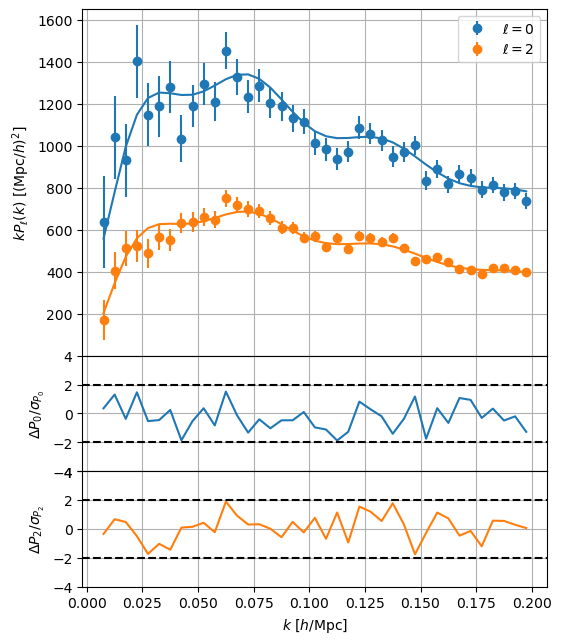

In [6]:
likelihood(**sampler.chains[0].choice(params=likelihood.varied_params))
observable.plot()
plt.show()

In [7]:
chain = sampler.chains[0].remove_burnin(0.5)
print(chain.to_stats(tablefmt='pretty'))

+---------+--------+-------+--------+-------+-----------------+-----------------+
|         | argmax | mean  | median |  std  | quantile:1sigma | interval:1sigma |
+---------+--------+-------+--------+-------+-----------------+-----------------+
| fnl_loc |  142   |  134  |  135   |  49   |     -48/+47     |    -43/+50.     |
|   b1    | 1.966  | 1.973 | 1.972  | 0.024 |  -0.023/+0.023  |  -0.025/+0.021  |
|   sn0   |   30   |  10   |   20   |  110  |    -110/+110    |   -117/+100.    |
| sigmas  |  0.06  | 0.24  |  0.22  | 0.16  |   -0.17/+0.17   |  -0.237/+0.067  |
+---------+--------+-------+--------+-------+-----------------+-----------------+


[000291.04] [0/1] 02-28 16:52  numexpr.utils             INFO     NumExpr defaulting to 8 threads.
Removed no burn in


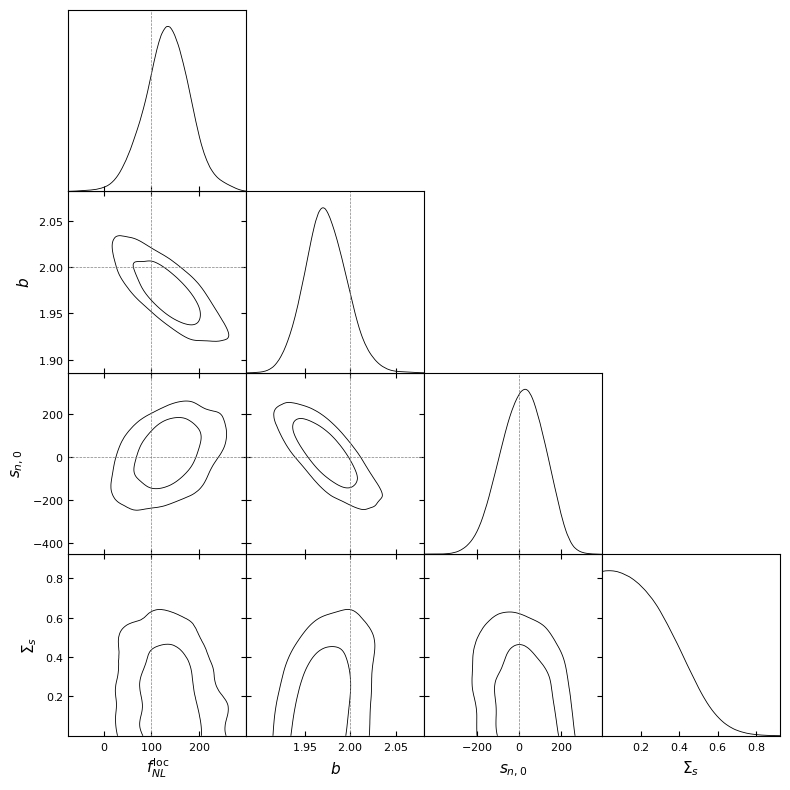

In [8]:
from desilike.samples import plotting
plotting.plot_triangle(chain, markers={'fnl_loc': 100., 'b1': b1, 'sn0': 0., 'sigmas': 0.})